In [33]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import os

# Setup
You need to have precomputed some files describing files locations in order for this notebook to run.

Take a look at notebook 1 in order to generate them.

In [29]:
datasets = ['timit', 'wavefake', 'mozilla', 'ljspeech']

In [34]:
os.makedirs('description', exist_ok=True)

# Compute Metrics for audio files across all datasets

In [30]:

# Function to calculate metrics for a single audio file
def get_audio_metrics(audio_file):
    # load
    y, sr = librosa.load(audio_file) 

    # metrics
    duration = librosa.get_duration(y=y, sr=sr)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    energy_distribution = librosa.feature.chroma_stft(S=np.abs(librosa.stft(y)), sr=sr)
    zero_crossings_rate = librosa.feature.zero_crossing_rate(y)

    return {
        "Audio File": audio_file,
        "Duration": duration,
        "Centroid": np.mean(centroid),
        "Rolloff": np.mean(rolloff),
        "Bandwidth": np.mean(bandwidth),
        "Energy Distribution": np.mean(energy_distribution),
        "Zero Crossings Rate": np.mean(zero_crossings_rate),
    }

In [31]:
datasets_dfs = []

# for each dataset
# compute metrics and store into a dataframe
# afterwards append to the list above
for dataset in datasets:
    d_file = f'{dataset}_data_files_summary.csv'
    audio_files = pd.read_csv(d_file).sample(n=100)['full_path'].to_list()
    # Initialize an empty list to store dictionaries of metrics
    results_list = []

    # Calculate metrics for each audio file in parallel and add them to the list
    results_list = Parallel(n_jobs=8)(delayed(get_audio_metrics)(audio_file) for audio_file in audio_files)

    # Create a Pandas DataFrame from the list
    dataset_results_df = pd.DataFrame(results_list)
    dataset_results_df['dataset'] = dataset
    dataset_results_df.to_csv(f'description/{dataset}_results.csv')
    datasets_dfs.append(dataset_results_df)

# concatenate all results
results_df = pd.concat(datasets_dfs)
results_df.head()

,Audio File,Duration,Centroid,Rolloff,Bandwidth,Energy Distribution,Zero Crossings Rate,dataset
0,F:\\downloads\\data\\lisa\\data\\timit\\raw\\T...,2.272018,2245.881495,3805.883789,1614.450299,0.570187,0.142005,timit
1,F:\\downloads\\data\\lisa\\data\\timit\\raw\\T...,4.153651,2307.280191,3982.620052,1596.259657,0.595174,0.142930,timit
2,F:\\downloads\\data\\lisa\\data\\timit\\raw\\T...,1.958458,2121.386970,3682.051068,1523.753195,0.631012,0.134432,timit
3,F:\\downloads\\data\\lisa\\data\\timit\\raw\\T...,3.840000,2613.300733,4772.133995,1911.442642,0.694953,0.202157,timit
4,F:\\downloads\\data\\lisa\\data\\timit\\raw\\T...,2.156825,2369.770854,3919.274509,1591.729667,0.669694,0.182460,timit


# Dataset Properties

In [38]:
results_df_g = results_df.groupby(['dataset']).agg(total_duration=('Duration', 'sum'),
                                                   n_samples=('Duration', 'count'),
                                                   mean_duration=('Duration', 'mean'),
                                                   min_duration=('Duration', 'min'),
                                                   max_duration=('Duration', 'max')
                                                   ).reset_index()
results_df_g

,dataset,total_duration,n_samples,mean_duration,min_duration,max_duration
0,ljspeech,629.659320,100,6.296593,1.702177,10.003311
1,mozilla,421.514104,100,4.215141,0.936009,19.896009
2,timit,308.721451,100,3.087215,1.427256,5.523265
3,wavefake,567.778095,100,5.677781,1.126168,10.054240


In [47]:
results_df_d = results_df.groupby('dataset').describe()
for c in results_df.columns:
    if c not in ['dataset', 'Audio File']:
        print(c)
        display(results_df_d[c])

Duration


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,100.0,6.296593,2.359104,1.702177,4.389887,6.531927,8.444671,10.003311
mozilla,100.0,4.215141,2.518367,0.936009,2.688027,3.744036,4.788016,19.896009
timit,100.0,3.087215,0.874996,1.427256,2.494422,2.944059,3.696043,5.523265
wavefake,100.0,5.677781,2.454615,1.126168,3.805397,5.607619,7.793197,10.054240


Centroid


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,100.0,2617.324288,304.658242,1995.868871,2417.624150,2567.378273,2808.657578,3412.976564
mozilla,100.0,2337.396073,611.733368,0.000000,1918.266725,2366.277719,2688.260139,3664.985912
timit,100.0,2159.241304,285.117062,1639.113537,1913.508354,2142.323596,2329.616696,3078.126352
wavefake,100.0,2621.814521,422.777853,1403.074154,2436.781771,2597.127590,2835.370392,4061.432828


Rolloff


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,100.0,4489.005480,419.874918,3323.861209,4263.384346,4526.341180,4760.507168,5526.224459
mozilla,100.0,4469.889050,1201.024898,0.000000,3720.019172,4554.560079,5342.370455,7446.193407
timit,100.0,3780.730798,439.322802,2916.403198,3461.318125,3779.222699,4075.473205,5001.395811
wavefake,100.0,4507.398226,573.190155,2497.096012,4228.848369,4491.124152,4789.544713,6205.517578


Bandwidth


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,100.0,2037.616067,98.323042,1717.574404,1971.186947,2045.306593,2106.875190,2280.214875
mozilla,100.0,2090.589523,489.505278,0.000000,1773.906476,2137.239668,2444.644920,3068.414486
timit,100.0,1602.579196,122.216492,1315.102633,1509.892915,1601.920444,1693.972146,1916.532572
wavefake,100.0,2057.611349,118.560058,1775.500911,1965.411417,2053.051438,2130.968064,2359.940353


Energy Distribution


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,100.0,0.540002,0.029595,0.450690,0.525515,0.541656,0.558453,0.645563
mozilla,100.0,0.616434,0.098355,0.000000,0.572767,0.630977,0.671693,0.796077
timit,100.0,0.617482,0.044139,0.511678,0.590176,0.622670,0.649978,0.717622
wavefake,100.0,0.539225,0.028964,0.423955,0.522192,0.536394,0.553148,0.641403


Zero Crossings Rate


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,100.0,0.160867,0.029739,0.098998,0.139528,0.155379,0.178188,0.262481
mozilla,100.0,0.149767,0.061760,0.000000,0.106025,0.141432,0.187494,0.313781
timit,100.0,0.143073,0.029329,0.079286,0.122401,0.140735,0.159903,0.236426
wavefake,100.0,0.157720,0.043307,0.041546,0.141501,0.157672,0.182962,0.295639


# Metrics Histograms across Datasets

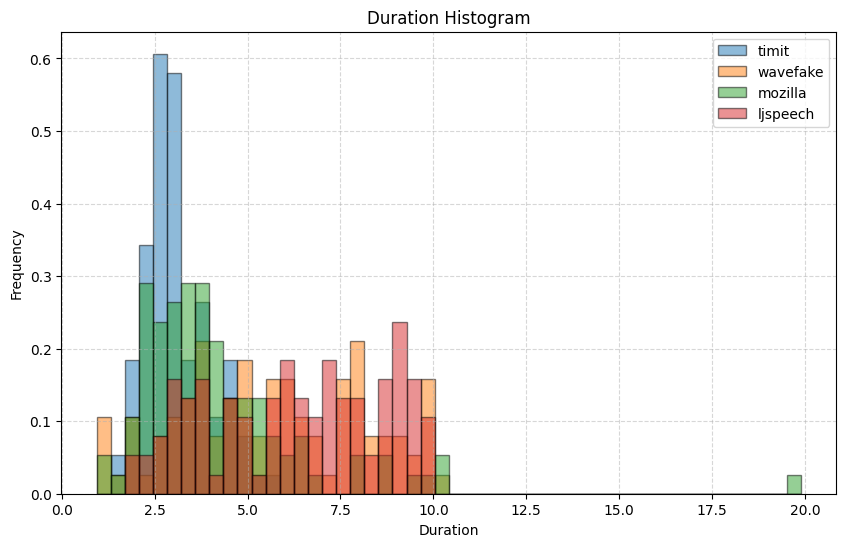

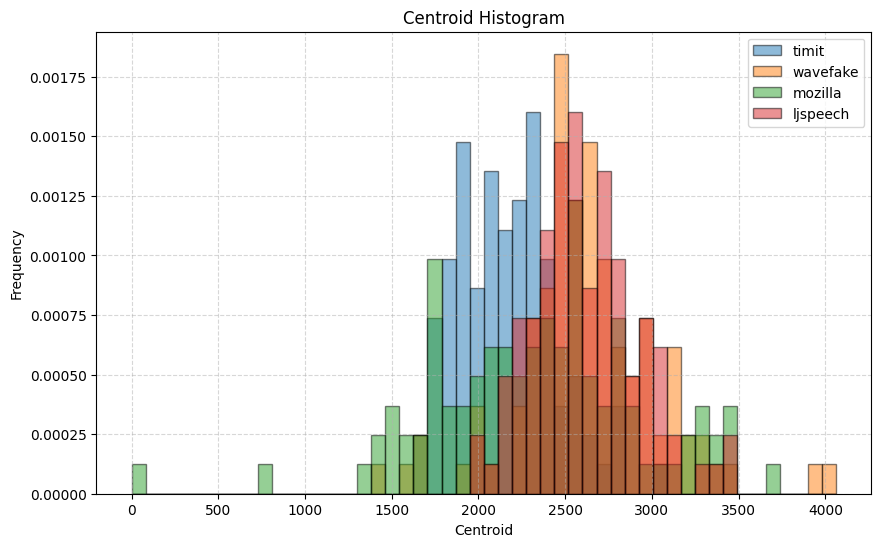

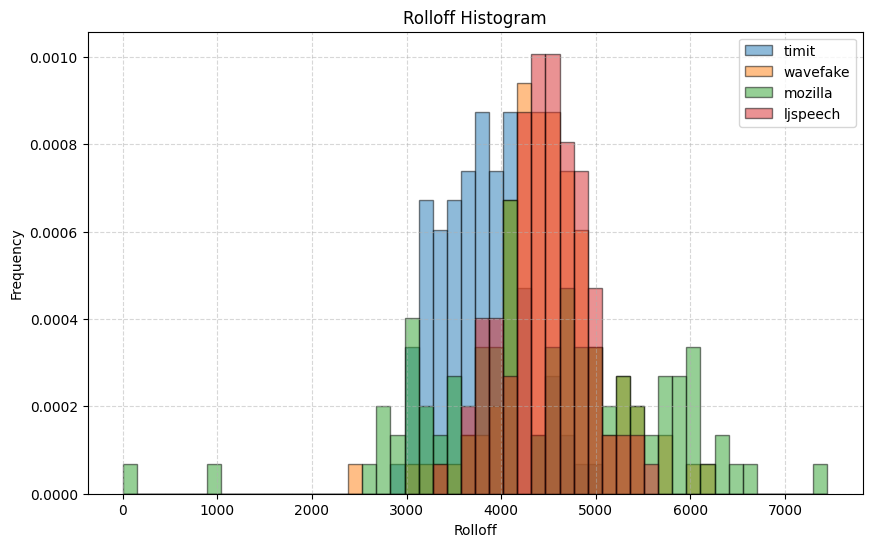

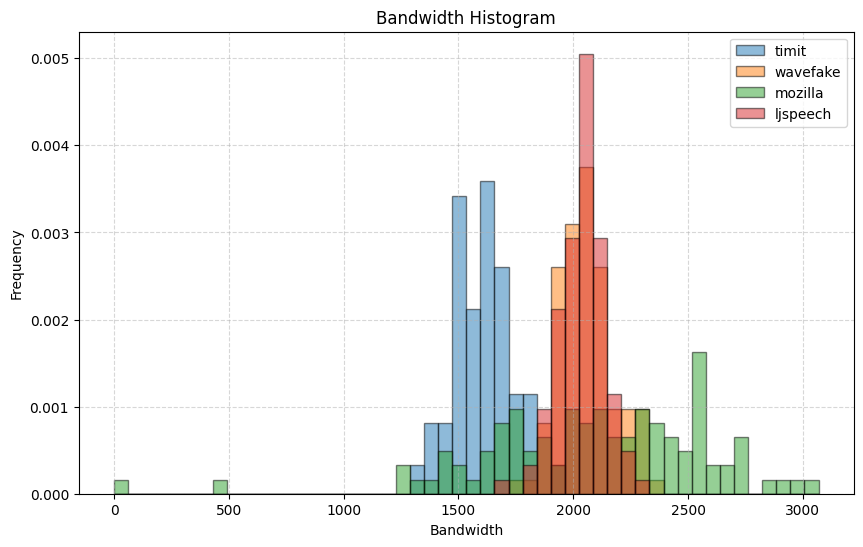

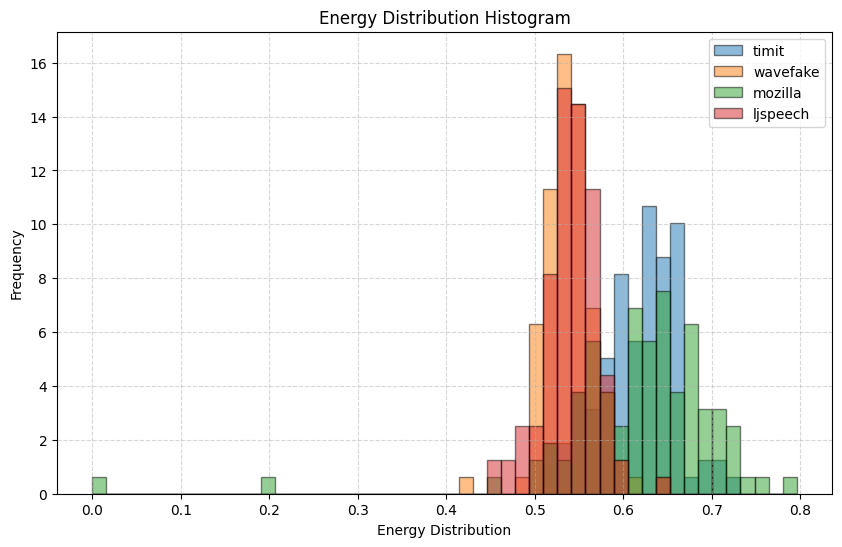

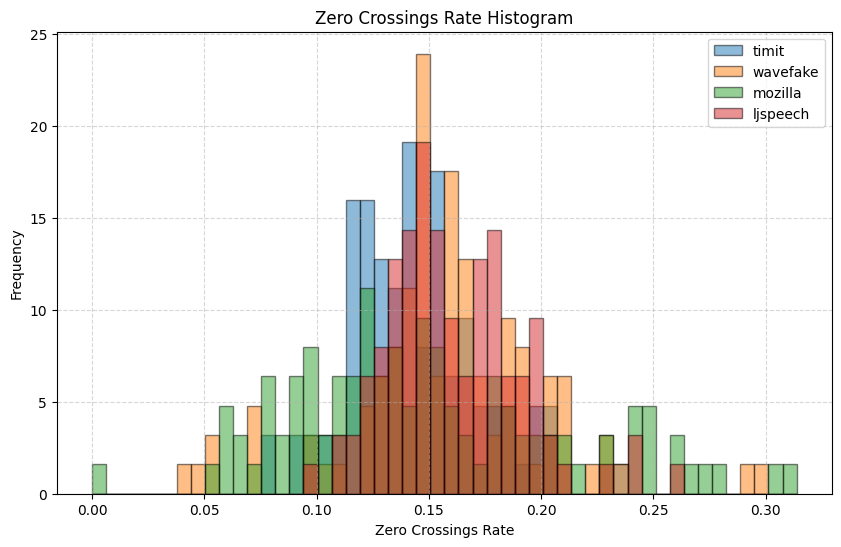

In [39]:
for metric_name in results_df.columns:
    # skip invalid columns
    if metric_name in ['Audio File', 'dataset']:
        continue
    
    num_bins = 50
    max_v = results_df[metric_name].max()
    min_v = results_df[metric_name].min()
    bin_positions = [min_v + (i * (max_v-min_v) / num_bins) for i in range(num_bins + 1)]
    plt.figure(figsize=(10, 6)) 
    for d in results_df['dataset'].unique():
        values = results_df.loc[results_df['dataset']==d, metric_name]   
        plt.hist(values,  bins=bin_positions, edgecolor='black', alpha=0.5, label=d, density=True)
    
    plt.title(f"{metric_name} Histogram")
    plt.xlabel(metric_name)
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()